# Predicción de precios de casas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import own library with custom technical routines
from custom_routines import custom_routines as cr

In [2]:
data = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/housing.data", header=None, delim_whitespace=True)

## Estimador con regresión polinómica
Proponemos ajustar los datos con un modelo con 13 variables explicativas y una de respuesta (el precio de las casas). 

Buscamos usar un modelo de la forma
$$ f(\bar x) = a_0+\sum_{i=1}^{12} a_i\Phi(x_i),$$
donde $\Phi(x_i) = x_i +
Para usar mínimos cuadrados, la función de error asociada al modelo es: 
$$ E(a) = \frac{1}{2}\sum_{j=1}^{506} (y_j-f(\bar x^j)$$

Buscamos la tupla $a = (a_0,a_1,\dots, a_{12})$ que minimiza a $E$, la cual se obtiene con la siguiente fórmula: 

$$ a_{lsq} = (X^TX)^{-1}X^Ty,$$
donde $X$ es la matriz de $12\times 12$ con todos los valores de las variables dependientes, $X^T$ es su transpuesta, y $y$ es el vector de los valores de la variable respuesta. 

Debajo calculamos $a_{lsq}$. 

In [3]:
#gs = plt.GridSpec(5,3)
#fig = plt.figure(figsize=(16,16))
#for i in range(0,4): 
#    for j in range(0,3):
#        fig.add_subplot(gs[i,j]).plot(X[0:,(3*i)+j], y, 'ko', label = (3*i)+j)
#        plt.legend()
#fig.add_subplot(gs[4,0]).plot(X[0:,12], y, 'ko', label = 12)
#plt.legend()
#fig.add_subplot(gs[4,1]).plot(y, y, 'ko', label = 13)
#plt.legend()

In [4]:
# Function for crossvalidation
from sklearn.model_selection import train_test_split
def cvk(model, Matrix, k):
    cv_results = np.zeros(shape=(k,2))
    for i in range(0,k):
        train_set_i, test_set_i = train_test_split(Matrix, test_size = 0.30, random_state = i)
        X_i = train_set_i[0:,:-1]
        y_i = train_set_i[0:,-1]
        model.fit(X_i,y_i)
    
        # Training error
        cv_results[i][0] = cr.sqerror(model.predict(X_i),y_i)
    
        # Validation error
        Xv_i = test_set_i[0:,:-1]
        yv_i = test_set_i[0:,-1]
        cv_results[i][1] = cr.sqerror(model.predict(Xv_i),yv_i)
        
    return cv_results

### Fitting a polynomial model with no interactions

In [5]:
# Example of building model matrix using a polynomial expansion of degree d
d = 1
X = cr.modelMatrix(data.values[0:,:-1],d)
y = data.values[0:,-1]
print("Dim of X:", len(X),"x",len(X[0]))
from sklearn import linear_model
dmodel = linear_model.LinearRegression()
dmodel.fit(X,y)
cvk(dmodel, np.column_stack((X, y)), 10)

Dim of X: 506 x 14


array([[2.99364108, 3.30306864],
       [3.15756768, 2.98726269],
       [3.09411797, 3.13718031],
       [3.10994077, 3.11048566],
       [2.94830983, 3.40299554],
       [2.94802947, 3.42416616],
       [2.96944326, 3.3438461 ],
       [3.05558738, 3.24912874],
       [3.06573072, 3.16615755],
       [3.14279612, 2.95988482]])

In [6]:
from sklearn import linear_model
dmodel = linear_model.LinearRegression()

# Look for best degree among 1 to 31
results = np.zeros(shape=(30,2))
for d in range(0,30):
    X = cr.modelMatrix(data.values[0:,:-1], d + 1)
    dmodel.fit(X,y)
    # Evaluation by cross-validation, k = 10
    a = cvk(dmodel, np.column_stack((X,y)), 10)
    
    results[d][0] = a[0:,0].mean()
    results[d][1] = a[0:,1].mean()
    # Evaluation by simple error on training set
    #results[d] = cr.sqerror(dmodel.predict(X),y)

Min Error on validation set 2.412638120706675 for degree  4
[2.41263812 3.00938998]


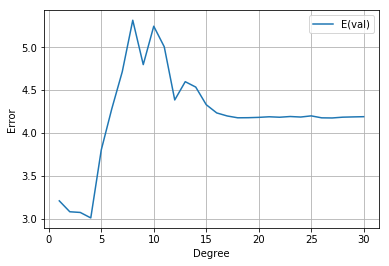

In [7]:
# Minimum error and degree among 1,...,31 that ensures it
print("Min Error on validation set", np.min(results[0:,0]), "for degree ", np.argmin(results[0:,1]) + 1)
print(results[3])

#plt.plot(np.arange(1,31), results)
plt.plot(np.arange(1,31), results[0:,0], label = "E(train)")
plt.plot(np.arange(1,31), results[0:,1], label = "E(val)")
plt.legend()
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Degree")
plt.show()

### Fitting a polynomial model with interactions

In [8]:
from sklearn.preprocessing import PolynomialFeatures

In [9]:
dmodel = linear_model.LinearRegression(fit_intercept = False)#, normalize = True)

y = data.values[0:,-1]
results = np.zeros(shape=(7,2))
for d in range(0,7):
    poly = PolynomialFeatures(d+1)
    pX = poly.fit_transform(data.values[0:,:-1])
    print(len(pX),len(pX[0]))
    dmodel.fit(pX,y)
    
    # Evaluation by cross-validation, k = 10
    a = cvk(dmodel, np.column_stack((pX,y)), 10)
    
    results[d][0] = a[0:,0].mean()
    results[d][1] = a[0:,1].mean()
    print(results[d][0],results[d][1])
    
    #results[d] = cr.sqerror(dmodel.predict(pX),y)

    # Evaluation by cross-validation, k = 10
    #results[d] = cvk(dmodel, d + 1, 10).mean()
    # Evaluation by simple error on training set
    #results[d] = cr.sqerror(dmodel.predict(X),y)

506 14
3.0485164285508315 3.208417621156007
506 105
1.613540641445013 2.89055163013549
506 560
-36.76448280455678 10.324090536538204
506 2380
-44.28337404869727 10.84410164623011
506 8568
-43.932245141882866 10.666742442748035
506 27132
-43.66865111670192 11.018237458617937
506 77520
-43.45996972446565 11.121258686757223


Min Error: 2.89055163013549 for degree  2
[3.04851643 3.20841762]
[1.61354064 2.89055163]
[-36.7644828   10.32409054]


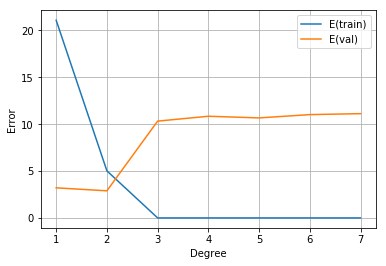

In [10]:
# Minimum error and degree among 1,...,8 that ensures it
print("Min Error:", np.min(results[0:,1]), "for degree ", np.argmin(results[0:,1]) + 1)
print(results[0])
print(results[1])
print(results[2])
#plt.plot(np.arange(1,7), results)
plt.plot(np.arange(1,8), [np.exp(i) for i in results[0:,0]], label = "E(train)")
plt.plot(np.arange(1,8), results[0:,1], label = "E(val)")
plt.legend()
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Degree")
plt.show()